#Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from tqdm.notebook import tqdm, trange
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Layer,
    Dropout,
    BatchNormalization,
    ReLU,
    LeakyReLU,
    Dense, 
    Flatten, 
    MaxPool2D, 
    Activation,
    LSTM,
)
from tensorflow.keras.models import Sequential
from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

#Data

In [ ]:
!unzip -q /content/drive/MyDrive/Models/Music_Generation/midi_songs.zip -d /content/

In [ ]:
seed = 2457
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000
data_dir = "/content/midi_songs"

In [ ]:
filenames = glob.glob(data_dir+'/**.mid')
print('Number of files:', len(filenames))

Number of files: 92


In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
sample_file = filenames[4]
print(sample_file)
pm = pretty_midi.PrettyMIDI(sample_file)
display_audio(pm)

/content/midi_songs/Rydia_pc.mid


In [ ]:
print('Number of instruments:', len(pm.instruments))
print('Instrument name:', pretty_midi.program_to_instrument_name(pm.instruments[0].program))

Number of instruments: 2
Instrument name: Acoustic Grand Piano


#Data Visualization

###Notes

In [ ]:
instrument = pm.instruments[0]

for i, note in enumerate(instrument.notes[:15]):
  print(f'{i}: pitch={note.pitch}, note_name={pretty_midi.note_number_to_name(note.pitch)},'
        f' duration={note.end - note.start:.4f}')

0: pitch=91, note_name=G6, duration=0.3659
1: pitch=86, note_name=D6, duration=0.3659
2: pitch=79, note_name=G5, duration=1.6463
3: pitch=91, note_name=G6, duration=0.3659
4: pitch=86, note_name=D6, duration=0.3659
5: pitch=79, note_name=G5, duration=1.6463
6: pitch=91, note_name=G6, duration=0.3659
7: pitch=86, note_name=D6, duration=0.3659
8: pitch=79, note_name=G5, duration=1.6463
9: pitch=91, note_name=G6, duration=0.3659
10: pitch=86, note_name=D6, duration=0.3659
11: pitch=79, note_name=G5, duration=1.6463
12: pitch=91, note_name=G6, duration=0.3659
13: pitch=86, note_name=D6, duration=0.3659
14: pitch=79, note_name=G5, duration=1.6463


##DataFrame


In [ ]:
def midi_to_df(files: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(files)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)
  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start
  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start
  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})
music_df = midi_to_df(sample_file)
music_df.head(10)

,pitch,start,end,step,duration
0,91,0.365853,0.731707,0.000000,0.365853
1,86,0.731707,1.097560,0.365853,0.365853
2,79,1.097560,2.743901,0.365853,1.646341
3,91,3.292682,3.658535,2.195121,0.365854
4,86,3.658535,4.024388,0.365854,0.365853
5,79,4.024388,5.670729,0.365853,1.646341
6,91,6.219510,6.585363,2.195121,0.365854
7,86,6.585363,6.951217,0.365854,0.365854
8,79,6.951217,8.597557,0.365854,1.646341
9,91,9.146337,9.512191,2.195121,0.365854


In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(music_df['pitch'])
sample_note_names[:10]

array(['G6', 'D6', 'G5', 'G6', 'D6', 'G5', 'G6', 'D6', 'G5', 'G6'],
      dtype='<U3')

##Plot Piano

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

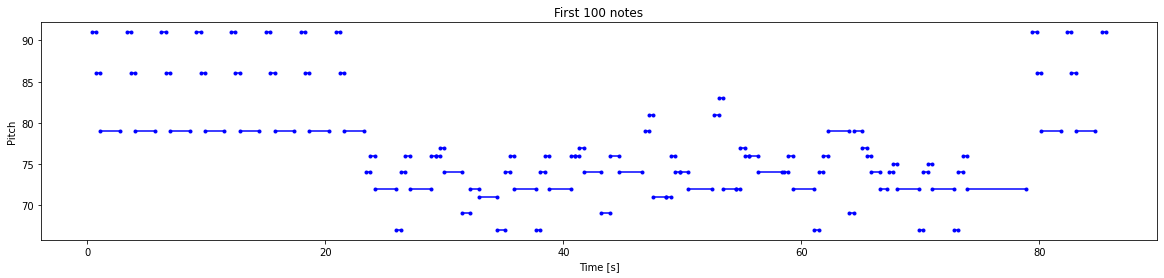

In [ ]:
plot_piano_roll(music_df, count=100)

##Plot distributions

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

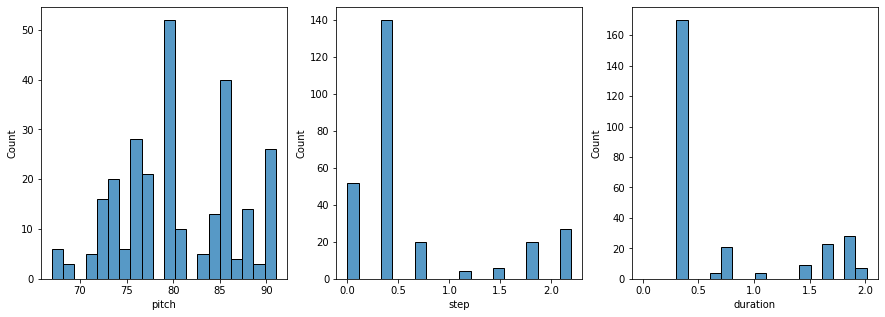

In [ ]:
plot_distributions(music_df)

##Create a MIDI file

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    music_df, out_file=example_file, instrument_name=pretty_midi.program_to_instrument_name(pm.instruments[0].program))

In [ ]:
display_audio(example_pm)

#Input Pipeline

In [ ]:
all_notes = []
for f in filenames:
  notes = midi_to_df(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 41002


In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

##Create Sequences

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

NameError: ignored

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.484375  0.        0.555555 ]
 [0.5078125 0.        0.555555 ]
 [0.5390625 0.        0.555555 ]
 [0.46875   0.666666  0.555555 ]
 [0.5078125 0.        0.555555 ]
 [0.5390625 0.        0.555555 ]
 [0.5625    0.        0.555555 ]
 [0.4609375 0.666666  0.888888 ]
 [0.484375  0.        0.888888 ]
 [0.5234375 0.        0.888888 ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=69.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.3263885625000005>}


In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

#Model

In [ ]:
!wget https://raw.githubusercontent.com/Skuldur/Classical-Piano-Composer/master/weights.hdf5

--2022-07-28 16:33:23--  https://raw.githubusercontent.com/Skuldur/Classical-Piano-Composer/master/weights.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43699036 (42M) [application/octet-stream]
Saving to: ‘weights.hdf5’

weights.hdf5        100%[===================>]  41.67M   119MB/s    in 0.4s    

2022-07-28 16:33:24 (119 MB/s) - ‘weights.hdf5’ saved [43699036/43699036]



In [ ]:
def create_network(n_vocab,learning_rate=0.001, input_shape = (25, 1)):

    inputs = tf.keras.Input(input_shape)
    x = (LSTM(
        512,
        input_shape=input_shape,
        recurrent_dropout=0.3,
        return_sequences=True
    ))(inputs)
    x = (LSTM(512, return_sequences=True, recurrent_dropout=0.3,))(x)
    x = (LSTM(512))(x)
    x = (BatchNormalization())(x)
    x = (Dropout(0.3))(x)
    x = (Dense(256))(x)
    x = (Activation('relu'))(x)
    x = (BatchNormalization())(x)
    x = (Dropout(0.3))(x)
    x = (Dense(n_vocab))(x)
    outputs = (Activation('softmax'))(x)

    # outputs = {
    #     'pitch': tf.keras.layers.Dense(n_vocab, name='pitch')(x),
    #     'step': tf.keras.layers.Dense(1, name='step')(x),
    #     'duration': tf.keras.layers.Dense(1, name='duration')(x),
    # }

    model = tf.keras.Model(inputs, outputs)

    # loss = {
    #     'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
    #         from_logits=True),
    #     'step': mse_with_positive_pressure,
    #     'duration': mse_with_positive_pressure,
    # }

    # optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # model.compile(
    #     loss=loss,
    #     loss_weights={
    #         'pitch': 0.05,
    #         'step': 1.0,
    #         'duration':1.0},
    #     optimizer=optimizer,
    # )

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    model.load_weights('weights.hdf5')
    model.summary()
    return model

In [ ]:
model = create_network(279)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 25, 1)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 25, 512)           1052672   
                                                                 
 lstm_7 (LSTM)               (None, 25, 512)           2099200   
                                                                 
 lstm_8 (LSTM)               (None, 512)               2099200   
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                           

In [ ]:
# losses = model.evaluate(train_ds, return_dict=True)
# losses

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/Models/Music_Generation/Checkpoints/ckpt_{epoch}',
        save_weights_only=True)
]

In [ ]:
import os

In [ ]:
# checkpoint_path = os.path.join('/content/drive/MyDrive/Models/Music_Generation/Checkpoints/')
# checkpoint_dir = os.path.dirname(checkpoint_path)
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# model.load_weights(latest)

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

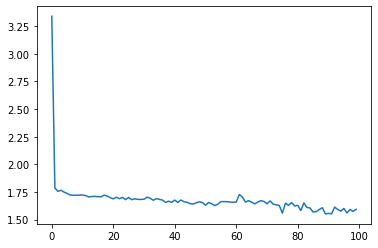

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [ ]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 10
num_predictions = 120

sample_notes = np.stack([music_df[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
#   pitch, step, duration = predict_next_note(input_notes, model, temperature)
  pitch = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [ ]:
!wget https://raw.githubusercontent.com/Skuldur/Classical-Piano-Composer/master/data/notes

--2022-07-28 16:39:33--  https://raw.githubusercontent.com/Skuldur/Classical-Piano-Composer/master/data/notes
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349984 (342K) [application/octet-stream]
Saving to: ‘notes’

notes               100%[===================>] 341.78K  --.-KB/s    in 0.005s  

2022-07-28 16:39:33 (68.2 MB/s) - ‘notes’ saved [349984/349984]



In [ ]:
import pickle

In [ ]:
def generate_notes(model, network_input):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    with open('data/notes', 'rb') as filepath:
        notes = pickle.load(filepath)

    pitchnames = sorted(set(item for item in notes))
    n_vocab = len(set(notes))
    start = np.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = np.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

In [ ]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,23,3.911164,22.976713,3.911164,26.887877
1,125,10.759699,26.930178,14.670863,41.601040
2,125,0.000000,124.387932,14.670863,139.058794
3,125,0.916762,195.093872,15.587625,210.681497
4,125,4.396734,112.404350,19.984359,132.388709
5,125,0.642081,165.156754,20.626440,185.783193
6,125,2.198870,109.670395,22.825310,132.495705
7,125,0.000000,239.959198,22.825310,262.784508
8,125,0.000000,181.793533,22.825310,204.618843
9,125,2.638940,87.693848,25.464250,113.158098


In [ ]:
out_file = 'output2.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=pretty_midi.program_to_instrument_name(pm.instruments[0].program))
display_audio(out_pm)

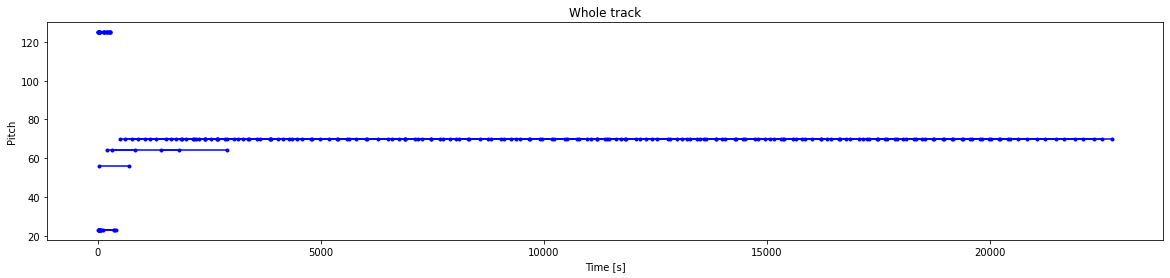

In [ ]:
plot_piano_roll(generated_notes)

In [ ]:
!rm -rf /content/drive/MyDrive/Models/Music_Generation/Checkpoints/*